In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 23 2018

@author: cesarechavarria
"""
import matplotlib
#matplotlib.use('Agg')
import cv2
import os
import sys
import optparse
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc,interpolate,stats,signal, spatial, ndimage
import json
import re
import pylab as pl
import seaborn as sns
import pandas as pd
import h5py
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ==================================== miscellaneous functions ========================================
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
def load_obj(name):
    with open(name, 'r') as r:
        fileinfo = json.load(r)
    return fileinfo
    
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def write_to_hdf5_struct(file_grp,path,array):
    if path not in file_grp.keys():
        dset = file_grp.create_dataset(path,array.shape,array.dtype)
        dset[...] = array

# ==================================== MAIN FUNCTIONS ========================================        

def block_mean(im0, fact):
    #function to block-downsample an image by a given factor
    
    im1 = cv2.boxFilter(im0,0, (fact, fact), normalize = 1)
    im2 = cv2.resize(im1,None,fx=1.0/fact, fy=1.0/fact, interpolation = cv2.INTER_CUBIC)
    return im2
    
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy/fact * (X/fact) + Y/fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx/fact, sy/fact)
    return res


def get_frame_rate(relevant_dir):
    #get frame rate
    
    # READ IN FRAME TIMES FILE
    pfile=open(os.path.join(relevant_dir,'performance.txt'))

    #READ HEADERS AND FIND RELEVANT COLUMNS
    headers=pfile.readline()
    headers=headers.split()

    count = 0
    while count < len(headers):
        if headers[count]=='frame_rate':
            rate_idx=count
            break
        count = count + 1

    #read just first line
    for line in pfile:
        x=line.split()
        frame_rate = x[rate_idx]
        break
    pfile.close()
    return float(frame_rate)

def get_frame_attribute(relevant_dir,attr_string):
    #get frame-by-frame details
    
    # READ IN FRAME TIMES FILE
    pfile=open(os.path.join(relevant_dir,'frame_times.txt'))

    #READ HEADERS AND FIND RELEVANT COLUMNS
    headers=pfile.readline()
    headers=headers.split()

    count = 0
    while count < len(headers):
        if headers[count]== attr_string:
            sync_idx=count
            break
        count = count + 1

    frame_attr=[]
    # GET DESIRED DATA
    for line in pfile:
        x=line.split()
        frame_attr.append(x[sync_idx])

    frame_attr=np.array(map(float,frame_attr))
    pfile.close()

    return frame_attr


def get_feature_info(process_img, box_pt1, box_pt2, feature_thresh, target_feature='pupil',criterion='area'):
    #get feature info for pupil or corneal reflection
    
    #get grayscale
    if process_img.ndim>2:
        process_img=np.mean(process_img,2)
    #apply restriction box 
    process_img = process_img[box_pt1[1]:box_pt2[1],box_pt1[0]:box_pt2[0]]

    #threshold
    img_roi = np.zeros(process_img.shape)
    if target_feature == 'pupil':
        thresh_array =process_img<feature_thresh
    else:
        thresh_array =process_img>feature_thresh
    if np.sum(thresh_array)>0:#continue if some points have passed threshold
        if criterion == 'area':
            #look for largest area
            labeled, nr_objects = ndimage.label(thresh_array) 
            pix_area = np.zeros((nr_objects,))
            for i in range(nr_objects):
                pix_area[i] = len(np.where(labeled==i+1)[0])
            img_roi[labeled == (np.argmax(pix_area)+1)]=255
            img_roi = img_roi.astype('uint8')
        else:
            #look for region closes to center of box
            x = np.linspace(-1, 1, process_img.shape[1])
            y = np.linspace(-1, 1, process_img.shape[0])
            xv, yv = np.meshgrid(x, y)

            [radius,theta]=cart2pol(xv,yv)

            img_roi = np.zeros(process_img.shape)
            labeled, nr_objects = ndimage.label(thresh_array) 
            pix_distance = np.zeros((nr_objects,))
            for i in range(nr_objects):
                pix_distance[i] = np.min((labeled==i+1)*radius)
            img_roi[labeled == (np.argmin(pix_distance)+1)]=255
            img_roi = img_roi.astype('uint8')

        #get contours
        tmp, contours, hierarchy = cv2.findContours(img_roi,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        #find contour with most points
        pt_array =np.zeros((len(contours),))
        for count,cnt in enumerate(contours):
            pt_array[count] = len(cnt)
        if len(contours)>0 and np.max(pt_array)>=5:#otherwise ellipse fit will fail
            elp_idx = np.argmax(pt_array)

            #fit ellipse
            elp = cv2.fitEllipse(contours[elp_idx])

            #unpack values
            elp_center = tuple((elp[0][0]+box_pt1[0], elp[0][1]+box_pt1[1]))
            elp_axes = elp[1]
            elp_orientation = elp[2]
            return elp_center, elp_axes, elp_orientation
        else:
            return tuple((0,0)), tuple((0,0)), 0
    else:
        return tuple((0,0)), tuple((0,0)), 0
 

def get_interp_ind(idx, interp_sites, step):
    redo = 0
    interp_idx = idx + step
    if interp_idx in interp_sites:
        redo = 1
    while redo:
        redo = 0
        interp_idx = interp_idx + step
        if interp_idx in interp_sites:
            redo = 1
    return interp_idx
         
def interpolate_sites(var_array, interp_sites):
    array_interp = np.copy(var_array)
    for target_idx in interp_sites:
        if target_idx < var_array.size:
            ind_pre = get_interp_ind(target_idx, interp_sites, -1)
            ind_post = get_interp_ind(target_idx, interp_sites, 1)
        
            x_good = np.array([ind_pre,ind_post])
            y_good = np.hstack((var_array[ind_pre],var_array[ind_post]))
            interpF = interpolate.interp1d(x_good, y_good,1)
            new_value=interpF(target_idx)
        else:
            new_value = var_array[target_idx-1]
       

        array_interp[target_idx]=new_value
    return array_interp

def process_signal(var_array, interp_flag, filt_kernel=11):
    #Clean up singal by interpolating the odd missing values and median filtering
    
    #get sites to interpolate
    interp_list1 = np.where(var_array == 0)[0]
    interp_list2 = np.where(interp_flag== 1)[0]
    interp_sites = np.concatenate((interp_list1,interp_list2))
    interp_sites = np.unique(interp_sites)
    
    #get interpolated list
    var_interp = interpolate_sites(var_array, interp_sites)
    
    #do some medial filtering
    nice_array = signal.medfilt(var_interp, filt_kernel)
    return nice_array

def plot_whole_timecourse(tstamps,value,stim_on_times,label,filename):
    
    #figure formatting
    sns.set_style("white")
    sns.set_context("paper",font_scale = 2.5)
    fig,ax=plt.subplots(figsize = (24, 6))

    #mark stimulus onset times
    for f in stim_on_times:
        ax.axvline(x=f, linewidth=1, color='k',alpha = 0.2, linestyle = '--')
        
    
    #plot variable of interest along with blink events
    ax.plot(tstamps,value)
    ymin,ymax = ax.get_ylim()

    if len(blink_times)>0:
                ax.plot(blink_times, np.ones((len(blink_times),))*(ymax+1),'m*')
            
    # Label axes
    ax.set_xlabel('Time (secs)',fontsize = 18,weight = 'bold')
    ax.set_ylabel('%s'%(label),fontsize = 18,weight = 'bold')


    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    sns.despine(trim=True, offset=0, bottom=False, left=False, top = True, right = True,ax = ax)
    
    # Save figure
    fig.savefig(filename,dpi = 300)
    plt.close()

In [6]:
class struct():
    pass

In [20]:
options = struct()
options.source_dir = '../sample_data'
options.output_dir = '../sample_output'
options.baseline_time = 1.0

In [21]:
# Define directories
output_file_dir = os.path.join(options.output_dir,'files')
times_dir = os.path.join(options.source_dir,'times')

In [82]:
# Create output directories
output_plot_dir = os.path.join(options.output_dir,'plots/parsed_timecourse')
if not os.path.exists(output_plot_dir):
    os.makedirs(output_plot_dir)

In [14]:
# Load and unpack key features
input_fn = os.path.join(output_file_dir,'full_session_eyetracker_data_sample_data.h5')
print 'Loading eyetracker feature info from :%s'%(input_fn)

file_grp = h5py.File(input_fn, 'r')#open file

frame_rate = float(file_grp.attrs['frame_rate'])

camera_time = file_grp['camera_time'][:]
blink_events = file_grp['blink_events'][:]
blink_times = file_grp['blink_times'][:]
    
pupil_radius = file_grp['pupil_radius'][:]
pupil_aspect = file_grp['pupil_aspect_ratio'][:]
pupil_dist_rel = file_grp['pupil_dist_rel'][:]
pupil_motion_rel = file_grp['pupil_motion_rel'][:]

file_grp.close()

Loading eyetracker feature info from :../sample_output/files/full_session_eyetracker_data_sample_data.h5


KeyError: "Unable to open object (Object 'pupil_aspect' doesn't exist)"

In [24]:
# Get stimulus onset times
para_file =  [f for f in os.listdir(times_dir) if f.endswith('.json')][0]#assuming a single file for all tiffs in run
print 'Getting paradigm info from: %s'%(os.path.join(times_dir, para_file))
with open(os.path.join(times_dir, para_file), 'r') as f:
    trial_info = json.load(f)

baseline_frames = int(options.baseline_time*frame_rate)

iti_full_time = trial_info['trial00001']['iti_duration']/1E3#for pasing traces  
iti_post_time = iti_full_time - options.baseline_time
iti_post_frames = int(iti_post_time*frame_rate)

stim_on_time = trial_info['trial00001']['stim_on_times']/1E3#convert to secs
stim_off_time = trial_info['trial00001']['stim_off_times']/1E3#convert to sec
stim_dur_time = stim_off_time - stim_on_time
stim_dur_frames = int(stim_dur_time*frame_rate)

post_onset_frames = stim_dur_frames+iti_post_frames

trial_time = np.arange(0,(1.0/frame_rate)*(baseline_frames+stim_dur_frames+iti_post_frames),1/frame_rate) - options.baseline_time

Getting paradigm info from: ../sample_data/times/parsed_trials.json


In [56]:
data_df = []
for ntrial in range(0, 100):
    if ntrial%100 == 0:
        print 'Parsing trial %d of %d'%(ntrial,len(trial_info))
    trial_string = 'trial%05d'%(ntrial+1)
    
    #get times and indices of relevent events
    stim_on_time = trial_info[trial_string]['stim_on_times']/1E3#convert to ms
    on_idx = np.where(camera_time>=stim_on_time)[0][0]
    start_idx = on_idx - baseline_frames
    end_idx = on_idx + post_onset_frames
    off_idx = on_idx + stim_dur_frames
        
    data_df.append(pd.DataFrame({'Time':trial_time,\
                                 'Pupil_Size':pupil_radius[start_idx:end_idx] - np.mean(pupil_radius[start_idx:on_idx]),\
                                 'Pupil_Motion':pupil_motion_rel[start_idx:end_idx] - np.mean(pupil_motion_rel[start_idx:on_idx]),\
                                 'Trial':[ntrial for x in trial_time]
                 }))
data_df = pd.concat(data_df,axis = 0)

Parsing trial 0 of 160


In [85]:
def make_parsed_plot(data_df, metric, label, figure_fn):
    # Plot parsed metric timecourse
    
    fig, ax = pl.subplots(figsize = (8,5))
    
    # plot values over individual presentations 
    sns.lineplot(data = data_df,x = 'Time',y = metric, units = 'Trial',color = 'b',estimator = None,ax = ax,\
                 **dict(alpha=0.05))
    # plot average value over time
    sns.lineplot(data = data_df,x = 'Time',y = metric,color = 'k',ax = ax)

    #mark stimulus onset and offset
    ymin, ymax = ax.get_ylim()
    ax.axvline(x=0, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='--')
    ax.axvline(x=1, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='-.')
    
    # label axes
    ax.set_xlabel('Time ASO',fontsize=16, weight = 'bold')
    ax.set_ylabel('%s'%(label),fontsize=16, weight = 'bold')

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    sns.despine(trim=True, offset=0, bottom=False, left=False, top = True, right = True,ax = ax)
    
    fig.savefig(figure_fn,dpi = 300, bbox_inches = 'tight')
    plt.close()

In [86]:
fig_fn = os.path.join(output_plot_dir,'parsed_pupil_size_vs_time.png')
make_parsed_plot(data_df,'Pupil_Size', 'Pupil Size (pixels)',fig_fn)

fig_fn = os.path.join(output_plot_dir,'parsed_pupil_motion_vs_time.png')
make_parsed_plot(data_df,'Pupil_Motion', 'Pupil Motion (pixels)',fig_fn)

#save dataframe to file
data_df.to_pickle(os.path.join(output_file_dir,'trial_parsed_metric_timecourse_df.pkl'))

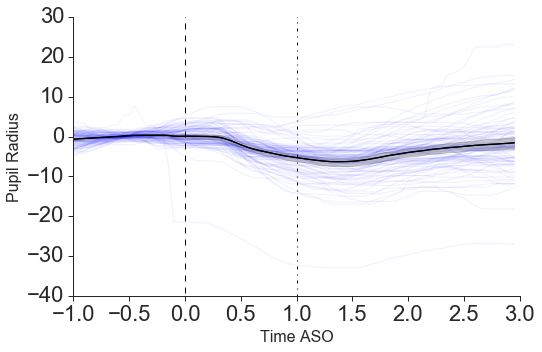

In [74]:
fig, ax = pl.subplots(figsize = (8,5))
sns.lineplot(data = data_df,x = 'Time',y = 'Pupil_Size', units = 'Trial',color = 'b',estimator = None,ax = ax,\
             **dict(alpha=0.05))
sns.lineplot(data = data_df,x = 'Time',y = 'Pupil_Size',color = 'k',ax = ax)

ax.plot(trial_time, np.nanmean(pup_rad_mat,0),'k',alpha=1)
ymin, ymax = ax.get_ylim()
ax.axvline(x=0, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='--')
ax.axvline(x=1, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='-.')
ax.set_xlabel('Time ASO',fontsize=16)
ax.set_ylabel('Pupil Radius',fontsize=16)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
sns.despine(trim=True, offset=0, bottom=False, left=False, top = True, right = True,ax = ax)

In [44]:
pupil_radius[on_idx:off_idx].shape

(20,)

In [46]:
on_idx

11417

In [47]:
off_idx

11437

In [45]:
trial_time.shape

(80,)

Parsing trial 0 of 160


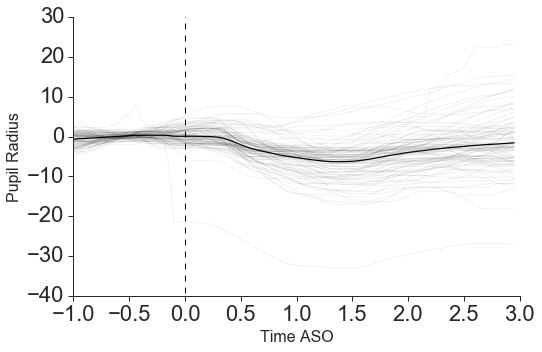

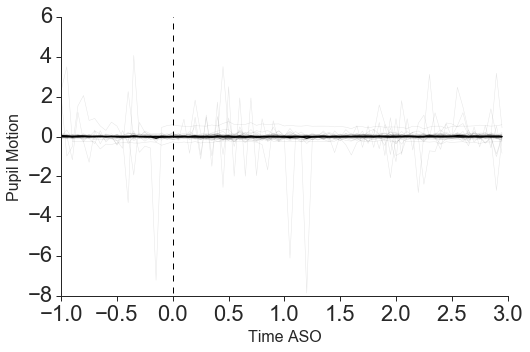

In [42]:
# Parse metrics for each stimulus presentation

#St
eye_info = dict()
pup_rad_mat = []
pup_mot_mat = []

#figure formatting
sns.set_style("white")
sns.set_context("paper",font_scale = 2.5)
fig, ax = pl.subplots(figsize = (8,5))
fig2, ax2 = pl.subplots(figsize = (8,5))

for ntrial in range(0, 100):
    if ntrial%100 == 0:
        print 'Parsing trial %d of %d'%(ntrial,len(trial_info))
    trial_string = 'trial%05d'%(ntrial+1)

    #copy some details from paradigm file
    eye_info[trial_string] = dict()
    eye_info[trial_string]['stimuli'] = trial_info[trial_string]['stimuli']
    eye_info[trial_string]['stim_on_times'] = trial_info[trial_string]['stim_on_times']
    eye_info[trial_string]['stim_off_times'] = trial_info[trial_string]['stim_off_times']
    eye_info[trial_string]['iti_duration'] = trial_info[trial_string]['iti_duration']

    #get times and indices of relevent events
    stim_on_time = trial_info[trial_string]['stim_on_times']/1E3#convert to ms
    on_idx = np.where(camera_time>=stim_on_time)[0][0]
    start_idx = on_idx - baseline_frames
    end_idx = on_idx + post_onset_frames
    off_idx = on_idx + stim_dur_frames

    eye_info[trial_string]['start_idx'] = start_idx
    eye_info[trial_string]['on_idx'] = on_idx
    eye_info[trial_string]['end_idx'] = end_idx
    eye_info[trial_string]['off_idx'] = off_idx


    # get some feature values for stimulation and baseline periods
    pupil_sz_baseline = np.mean(pupil_radius[start_idx:on_idx])
    eye_info[trial_string]['pupil_size_stim'] = np.mean(pupil_radius[on_idx:off_idx])
    eye_info[trial_string]['pupil_size_baseline'] = np.mean(pupil_radius[start_idx:on_idx])
    
    pupil_mot_baseline = np.mean(pupil_motion_rel[start_idx:on_idx])
    eye_info[trial_string]['pupil_motion_stim'] = np.mean(pupil_motion_rel[on_idx:off_idx])
    eye_info[trial_string]['pupil_motion_baseline'] = np.mean(pupil_motion_rel[start_idx:on_idx])

    ax.plot(trial_time, pupil_radius[start_idx:end_idx]-pupil_sz_baseline,'k',alpha =0.1,linewidth = 0.5)
    pup_rad_mat.append(pupil_radius[start_idx:end_idx]-pupil_sz_baseline)


    ax2.plot(trial_time, pupil_motion_rel[start_idx:end_idx]-pupil_mot_baseline,'k',alpha =0.1,linewidth = 0.5)
    pup_mot_mat.append(pupil_motion_rel[start_idx:end_idx]-pupil_mot_baseline) 
 
# Formatting for first figure


# Formatting for second figure
ax2.plot(trial_time, np.nanmean(pup_mot_mat,0),'k',alpha=1)
ymin, ymax = ax2.get_ylim()
ax2.axvline(x=0, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='--')
ax2.set_xlabel('Time ASO',fontsize=16)
ax2.set_ylabel('Pupil Motion',fontsize=16)

# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
sns.despine(trim=True, offset=0, bottom=False, left=False, top = True, right = True,ax = ax2)

In [28]:
%matplotlib inline

In [33]:
len(pup_rad_mat)

100

In [ ]:

    #***Parse trace by trial ***
    eye_info = dict()

    pup_rad_mat = []
    pup_dist_mat = []
    fig, ax = pl.subplots()
    fig2, ax2 = pl.subplots()


    for ntrial in range(0, len((trial_info))):
        if ntrial%100 == 0:
            print 'Parsing trial %d of %d'%(ntrial,len(trial_info))
        trial_string = 'trial%05d'%(ntrial+1)
        
        #copy some details from paradigm file
        eye_info[trial_string] = dict()
        eye_info[trial_string]['stimuli'] = trial_info[trial_string]['stimuli']
        eye_info[trial_string]['stim_on_times'] = trial_info[trial_string]['stim_on_times']
        eye_info[trial_string]['stim_off_times'] = trial_info[trial_string]['stim_off_times']
        eye_info[trial_string]['iti_duration'] = trial_info[trial_string]['iti_duration']
        
        #get times and indices of relevent events
        stim_on_time = trial_info[trial_string]['stim_on_times']/1E3#convert to ms
        on_idx = np.where(camera_time>=stim_on_time)[0][0]
        start_idx = on_idx - baseline_frames
        end_idx = on_idx + post_onset_frames
        off_idx = on_idx + stim_dur_frames

        eye_info[trial_string]['start_idx'] = start_idx
        eye_info[trial_string]['on_idx'] = on_idx
        eye_info[trial_string]['end_idx'] = end_idx
        eye_info[trial_string]['off_idx'] = off_idx


        #get some feature values for stimulation and baseline periods
        pupil_sz_baseline = np.mean(pupil_dist[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_stim'] = np.mean(pupil_radius[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_stim_min'] = np.min(pupil_radius[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_stim_max'] = np.max(pupil_radius[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_baseline'] = np.mean(pupil_radius[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_baseline_min'] = np.min(pupil_radius[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_baseline_max'] = np.max(pupil_radius[start_idx:on_idx])

        eye_info[trial_string]['pupil_size_diff1_stim'] = np.mean(pupil_radius_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_diff1_stim_min'] = np.min(pupil_radius_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_diff1_stim_max'] = np.max(pupil_radius_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_diff1_baseline'] = np.mean(pupil_radius_diff1[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_diff1_baseline_min'] = np.min(pupil_radius_diff1[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_diff1_baseline_max'] = np.max(pupil_radius_diff1[start_idx:on_idx])
        
        pupil_dist_baseline = np.mean(pupil_dist[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_stim'] = np.mean(pupil_dist[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_stim_min'] = np.min(pupil_dist[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_stim_max'] = np.max(pupil_dist[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_baseline'] = np.mean(pupil_dist[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_baseline_min'] = np.min(pupil_dist[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_baseline_max'] = np.max(pupil_dist[start_idx:on_idx])

        eye_info[trial_string]['pupil_dist_diff1_stim'] = np.mean(pupil_dist_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_diff1_stim_min'] = np.min(pupil_dist_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_diff1_stim_max'] = np.max(pupil_dist_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_diff1_baseline'] = np.mean(pupil_dist_diff1[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_diff1_baseline_min'] = np.min(pupil_dist_diff1[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_diff1_baseline_max'] = np.max(pupil_dist_diff1[start_idx:on_idx])

        eye_info[trial_string]['pupil_x_stim'] = np.mean(pupil_x[on_idx:off_idx])
        eye_info[trial_string]['pupil_x_stim_min'] = np.min(pupil_x[on_idx:off_idx])
        eye_info[trial_string]['pupil_x_stim_max'] = np.max(pupil_x[on_idx:off_idx])
        eye_info[trial_string]['pupil_x_baseline'] = np.mean(pupil_x[start_idx:on_idx])
        eye_info[trial_string]['pupil_x_baseline_min'] = np.min(pupil_x[start_idx:on_idx])
        eye_info[trial_string]['pupil_x_baseline_max'] = np.max(pupil_x[start_idx:on_idx])

        eye_info[trial_string]['pupil_y_stim'] = np.mean(pupil_y[on_idx:off_idx])
        eye_info[trial_string]['pupil_y_stim_min'] = np.min(pupil_y[on_idx:off_idx])
        eye_info[trial_string]['pupil_y_stim_max'] = np.max(pupil_y[on_idx:off_idx])
        eye_info[trial_string]['pupil_y_baseline'] = np.mean(pupil_y[start_idx:on_idx])
        eye_info[trial_string]['pupil_y_baseline_min'] = np.min(pupil_y[start_idx:on_idx])
        eye_info[trial_string]['pupil_y_baseline_max'] = np.max(pupil_y[start_idx:on_idx])

        eye_info[trial_string]['blink_event_count_stim'] = np.sum(blink_events[on_idx:off_idx])
        eye_info[trial_string]['blink_event_count_baseline'] = np.sum(blink_events[start_idx:on_idx])

        eye_info[trial_string]['pupil_ratio_stim'] = np.mean(pupil_aspect[on_idx:off_idx])
        eye_info[trial_string]['pupil_ratio_stim_min'] = np.min(pupil_aspect[on_idx:off_idx])
        eye_info[trial_string]['pupil_ratio_stim_max'] = np.max(pupil_aspect[on_idx:off_idx])
        eye_info[trial_string]['pupil_ratio_baseline'] = np.mean(pupil_aspect[start_idx:on_idx])
        eye_info[trial_string]['pupil_ratio_baseline_min'] = np.min(pupil_aspect[start_idx:on_idx])
        eye_info[trial_string]['pupil_ratio_baseline_max'] = np.max(pupil_aspect[start_idx:on_idx])

        ax.plot(trial_time, pupil_radius[start_idx:end_idx]-pupil_sz_baseline,'k',alpha =0.1,linewidth = 0.5)
        pup_rad_mat.append(pupil_radius[start_idx:end_idx]-pupil_sz_baseline)
        
        ax2.plot(trial_time, pupil_dist[start_idx:end_idx]-pupil_dist_baseline,'k',alpha =0.1,linewidth = 0.5)
        pup_dist_mat.append(pupil_dist[start_idx:end_idx]-pupil_dist_baseline) 

   

    print 'Saving figures to: %s' % (output_fig_dir)
    ax.plot(trial_time, np.nanmean(pup_rad_mat,0),'k',alpha=1)
    ymin, ymax = ax.get_ylim()
    ax.axvline(x=0, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='--')
    ax.set_xlabel('Time ASO',fontsize=16)
    ax.set_ylabel('Pupil Radius',fontsize=16)
    sns.despine(offset=2, trim=True)

    fig_file = os.path.join(output_fig_dir,'parsed_pupil_size_%s_%s_%s.png'%(session,animalid,run))
    fig.savefig(fig_file, bbox_inches='tight')
    plt.close()

    ax2.plot(trial_time, np.nanmean(pup_dist_mat,0),'k',alpha=1)
    ymin, ymax = ax2.get_ylim()
    ax2.axvline(x=0, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='--')
    ax2.set_xlabel('Time ASO',fontsize=16)
    ax2.set_ylabel('Pupil Distance',fontsize=16)
    sns.despine(offset=2, trim=True)

    fig_file = os.path.join(output_fig_dir,'parsed_pupil_distance_%s_%s_%s.png'%(session,animalid,run))
    fig2.savefig(fig_file, bbox_inches='tight')
    pl.close()

    #save info to file
    output_fn = 'parsed_eye_%s_%s_%s.json'%(session,animalid,run)

    print 'Saving parsed eye info to: %s' % (os.path.join(output_file_dir,output_fn))

    with open(os.path.join(output_file_dir, output_fn), 'w') as f:
        trial_info = json.dump(eye_info,f)